# Linear Regression


## Read dataset and normalize 

In [1]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

file = open("/home/vutaliy/Downloads/LR/1.txt", "r") 
m = int(file.readline())
m += 1

# Read train and find mins, maxs
def readset(objs, min_max_set, size):
    for i in range(size): 
        current_obj = file.readline().split()
        buff = []

        for j in range(len(current_obj)):
            x = float(current_obj[j])
            buff.append(x)
            
            if x < min_max_set[j][0]:
                min_max_set[j][0] = x

            if x > min_max_set[j][1]:
                min_max_set[j][1] = x

        objs.append(buff)

# Min max scaler
def min_max(objs, mins_and_maxs): 
    for i in range(len(objs)):
        for j in range(len(objs[0])):
            objs[i][j] = (objs[i][j] - mins_and_maxs[j][0]) / (mins_and_maxs[j][1] - mins_and_maxs[j][0]) if mins_and_maxs[j][1] - mins_and_maxs[j][0] !=0 else 0

# Add free coef
def add_free_coef(objs):
    for i in range(len(objs)):
        objs[i].append(1.0)
        objs[i][m], objs[i][m-1] = objs[i][m-1], objs[i][m]

# train
n = int(file.readline())
train = []
min_max_train = [[float("inf"), float("-inf")] for i in range(m) ]
readset(train, min_max_train, n)
add_free_coef(train)

# test
k = int(file.readline())
test = []
min_max_test = [[float("inf"), float("-inf")] for i in range(m) ]
readset(test, min_max_test, k)
add_free_coef(test)

train = np.array(train)
y_ans_train = train[:,len(train[0])-1]
train = train[:,:len(train[0])-1]

# train = train[:,:len(train[0])-1].T
# print(train)
# train = np.vstack((np.ones_like(train[0]), train)).T
# scaler = MinMaxScaler()
# train = scaler.fit_transform(train)
min_max(train, min_max_train)
train[:,train.shape[1]-1] = 1



test = np.array(test)
y_ans_test = test[:,len(test[0])-1]
test = test[:,:len(test[0])-1]

# test = test[:,:len(test[0])-1].T
# print(test)
# test = np.vstack((np.ones_like(test[0]), test)).T
# test = scaler.fit_transform(test)
min_max(test, min_max_test)
test[:,test.shape[1]-1] = 1

# test = np.array(test)
# y_ans_test = test[:,len(test[0])-1]
# test = test[:,:len(test[0])-1]

## Functional assessment

In [2]:
def smape(preds_y, ans_y): # pls help me
    sum_ = 0
    for ix, pred in enumerate(preds_y):
        sum_ += abs(pred - ans_y[ix])/((abs(pred) + abs(ans_y[ix])/2))
    return 100 * (sum_ / len(preds_y))

def nmrse(preds_y, ans_y):
    sum_ = 0
    min_p = np.min(ans_y)
    max_p = np.max(ans_y)
    for ix, pred in enumerate(preds_y): # for pred, ans in zip(preds_y, ans_y)
        sum_ += (pred - ans_y[ix]) ** 2
    return ((sum_ / len(preds_y)) ** 0.5) / (max_p - min_p) 

## Least square method

$w = (A^T*A)^{-1}*A^T*y\ classic\ solution\\ $
$A = U*D*V^T\ svd\\ $
$A+ = (A^T*A)^{-1}*A^T\ pseudoinv matrix\\ $
$A+ = (V*D*U^T*U*D*V^T)^{-1}*V*D*U^T\ (U^T*U = E\ orthogonal)\\ $
$A+ = (V*D*D*V^T)^(-1)*V*D*U^T\\ $
$A+ = (V^T)^{-1}*D^{-1}*D^{-1}*V^{-1}*V*D*U^T\\ $
$A+ = V*D^{-1}U^T\\ $
$w^* = (A^T*A + \lambda *E)^{-1}*A^T*y\ solution\ with\ regularization\\ $
$w^* = V*(D^2 + \lambda *E)^{-1}*D*U^T*y\ ==\  y*U*(D^2 + \lambda *E)^{-1}*D*V^T$

In [3]:
import numpy as np
u, s, vt = np.linalg.svd(train, full_matrices=False)

def lsm():
    buff1 = []
    buff2 = []
    for i in range(1, 31000, 100):
        lmbd = 0.1 * i
        # classic # w = np.dot(np.dot(np.linalg.inv(np.dot(train.T, train) + lmbd * np.eye(train.shape[1])), train.T), y_ans_train)
        # swap matrices # w = np.dot(y_ans_train, np.dot(np.dot(np.dot(u, np.linalg.inv(np.diag(s ** 2) + lmbd * np.eye(s.shape[0]))), np.diag(s)), vt))
        
        w = np.dot(np.dot(np.dot(np.dot(vt.T, np.linalg.inv(np.diag(s ** 2) + lmbd * np.eye(s.shape[0]))), np.diag(s)), u.T), y_ans_train)
        y_preds = np.dot(test, w)
        buff1.append(lmbd)
        # print(y_preds, y_ans_test)
        buff2.append(nmrse(y_preds, y_ans_test))

    return buff1, buff2

lmbds, errs = lsm()


2840.1000000000004


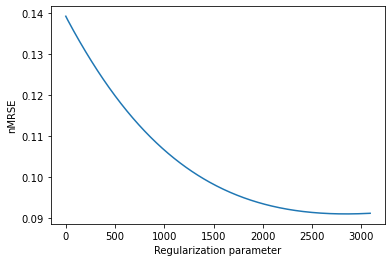

In [4]:
import matplotlib.pyplot as plt
print(lmbds[errs.index(min(errs))])
# print(min(errs))

plt.xlabel("Regularization parameter")
plt.ylabel("nMRSE")
plt.plot(lmbds, errs)

## Batch gradient descent

### Help functions


In [5]:
# loss function 
def sq(x, w, y):
    return (np.dot(x, w) - y) ** 2 / 2

def dif_sq(x, w, y):
    return np.dot((np.dot(x, w) - y), x)

def empirical_risk(w, func, start, k):
    return 1 / k * sum([func(train[i], w, y_ans_train[i]) for i in range(start, start + k + 1)])


In [6]:
import random as rnd
from math import sqrt

amount = 1000
batch_size = 1
loss = []

amounts = []
answs = []
amounts2 = []
answs2 = []

def bgd(amount, batch_size = sqrt(train.shape[1]), h = 1, lmbd2 = 1):
    lmbd = 1 / 3
    start = rnd.randint(0, len(train) - batch_size - 1)

    weights = np.array([rnd.uniform(-1/(2 * train.shape[1]), 1/(2 * train.shape[1])) for i in range(train.shape[1])])
    assessment = empirical_risk(weights, dif_sq, start, batch_size) + lmbd2 * np.sign(weights)

    for i in range(1, amount): 
        h = 1 / i
        start = rnd.randint(0, len(train) - batch_size - 1)
        weights -= h * assessment
        assessment = (1 - lmbd) * assessment + lmbd * (empirical_risk(weights, dif_sq, start, batch_size) + lmbd2 * np.sign(weights))

        amounts.append(i)
        amounts2.append(i)

        y_pred = np.dot(test, weights)
        y_pred2 = np.dot(train, weights)

        answs.append(nmrse(y_pred, y_ans_test))
        answs2.append(nmrse(y_pred2, y_ans_train))

    return weights

y_pred = np.dot(train, bgd(amount, batch_size)) 
print(nmrse(y_pred, y_ans_train))

def find_best_reg():
    regs = []
    scores = []
    for lmbd in range(0,15):
        regs.append(lmbd)
        y_pred = np.dot(test, bgd(amount, batch_size, lmbd2 = lmbd)) 
        scores.append(nmrse(y_pred, y_ans_test))
        print(lmbd)
    return regs[scores.index(min(scores))]

best_reg = find_best_reg()
print(best_reg)

NameError: name 'sqrt' is not defined

In [ ]:
# amounts = []
# answs = []
# amounts2 = []
# answs2 = []

fig, ax = plt.subplots()

buff = bgd(amount, lmbd2 = 58)

# def calculate_errs():
#     for i in range(2,1000):
#         amounts.append(i)
#         amounts2.append(i)
#         buff = bgd(i, lmbd2 = best_reg)
#         y_pred = np.dot(test, buff)
#         y_pred2 = np.dot(train, buff)
#         answs.append(nmrse(y_pred, y_ans_test))
#         answs2.append(nmrse(y_pred2, y_ans_train))
#         print(i)

# calculate_errs()

plt.xlabel("Amount of iterations")
plt.ylabel("nMRSE")

plt.plot(amounts, answs, label = 'test')
plt.plot(amounts2, answs2, label = 'train')

ax.legend()

fig.set_figheight(12)
fig.set_figwidth(12)
plt.show()
